# Determine a Reasonable Sample Size for Training a Text Classifier 

Date: 2023-01-13  
Author: Jason Beach  
Categories: Innovation, Data_Science  
Tags: nlp, statistics, sample_size

<!--eofm-->

Consider that we are creating a text classification model that will discover a few target needles in a massive haystack of records.  Maybe we are looking for messages of Death among emergency services messages - 20 for every 50,000 messages.  Labeling this large dataset and finding the Death messages is costly, so we don't want to label more than is necessary.  If we already have enough to estimate the target proportion, let us determine whether the sample size used for training the classification model is large enough.  Earler, in 'Sample_Size_Review.ipynb', we attempted to calculate _n_ from the Confidence Interval expression.  Now, we reverse this process to calculate the Prediction Interval from the selected _n_.

The following bootstrap steps are used to create Prediction Intervals from a sample.  We will use Recall as our scoring estimate and we will use the FastText model (the simplest text classifier) as a surrogate Continuous Bag Of Words (CBOW) model to quickly train and get results.

* create N models
* predict on test data, then get counts from confusion matrix
* create distribution of proportion missing (recall)
* estimate sigma of distribution

## Configure Environment

In [1]:
import os
path_current = os.getcwd()

In [2]:
! ls ../../GitLab/event-type/pipeline_components

encoder.py	 preprocess.py	Soln_EventType
io_component.py  __pycache__	streamarray.py


In [3]:
path_data = '../../Data/Event_Type/model6'
path_models = './models'
path_components = '../../GitLab/event-type/'

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

In [6]:
#(in term) apt install build-essential
#! pip install fasttext==0.9.2
#! pip install truecase

In [7]:
os.chdir( os.path.join(path_current, path_components) )

from pipeline_components.preprocess import preprocess_data

from pipeline_components import io_component
#from pipeline_components import encoder

In [8]:
os.chdir( path_current )

In [9]:
import dill 
import csv
import spacy 

In [10]:
import fasttext as ft
import pandas as pd
import numpy as np

In [11]:
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [12]:
ft.FastText.eprint = lambda x: None

In [13]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [14]:
filename = 'globalsave.pkl'
dill.dump_session(filename)

## Prepare Pipeline

### Pipeline Components

In [15]:
nlp_spacy = spacy.load("en_core_web_sm")

from pipeline_components import io_component
nlp_spacy.add_pipe('input_component', last=True)

from pipeline_components.Soln_EventType import reportableEvent, EVENT_ACTION
nlp_spacy.add_pipe("reportableEvent_component", last=True)

### Prepare Text

In [16]:
os.chdir( os.path.join(path_current, path_data) )

In [17]:
dt = pd.read_csv('train_sent_v6.csv')
dt_t = pd.read_csv('test_sent_v6.csv')

dt['label'] = '__label__' + dt['label'].astype(str)
dt_t['label'] = '__label__' + dt_t['label'].astype(str)

dfTrain = dt[['label', 'sentence']]
dfTest = dt_t[['label', 'sentence']]

In [18]:
dfTrain['label'].value_counts()

__label__Death       4220
__label__NonDeath    1448
Name: label, dtype: int64

In [19]:
dfTest['label'].value_counts()

__label__Death       499
__label__NonDeath    159
Name: label, dtype: int64

### Prepare Code

In [20]:
class Ensemble:
    def __init__(self, number_of_models, model_directory):
        self.number_of_models = number_of_models
        self.model_directory = model_directory
        self.ensemble = []
        
        self.prefix_model = 'fs_train_v'
        self.prefix_validate = 'fs_validate_v'
        
    def populate_ensemble_list(self):
        newlist = [os.path.join(dir, file) for file in os.listdir(dir) if '.bin' in file]
        self.ensemble.extend( newlist)
        
    def get_training_file(self, iteration):
        name_train = self.prefix_model + str(iteration) + '.txt'
        return os.path.join(self.model_directory, name_train)

    def get_validation_file(self, iteration):
        name_train = self.prefix_validate + str(iteration) + '.txt'
        return os.path.join(self.model_directory, name_train)    
    
    def get_model_binary(self, iteration):
        name_binary = self.prefix_model + str(iteration) + '.bin'
        return os.path.join(self.model_directory, name_binary)
    
    def get_model(self, model_idx):
        return ft.load_model( self.ensemble[model_idx] )
    
    def get_model_predictions(self, model_idx, text_list):
        model = ft.load_model( self.ensemble[model_idx] )
        predictions = [model.predict(text)[0][0] for text in text_list]     #<<< this should take the text list directly - no need for a list comprhension
        return predictions
        
    def create_datasets(self, dfTrain, dfTest, frac):
        for iteration in range(1, (self.number_of_models+1) ):
            name_train = self.get_training_file(iteration)
            name_validate = self.get_validation_file(iteration)
    
            train = dfTrain.sample(frac=FRAC, replace=True, random_state=iteration)
            idx = list(set(dfTrain.index) - set(train.index))
            validate = dfTrain.iloc[idx]
            #dfValidate = pd.concat([dfTest, validate], ignore_index=True)
            #preprocessing is already performed
            train.to_csv(name_train, 
                                          index = False, 
                                          sep = ' ',
                                          header = None, 
                                          quoting = csv.QUOTE_NONE, 
                                          quotechar = "", 
                                          escapechar = " ")
            validate.to_csv(name_validate, 
                                          index = False, 
                                          sep = ' ',
                                          header = None, 
                                          quoting = csv.QUOTE_NONE, 
                                          quotechar = "", 
                                          escapechar = " ")
            
        print(f'completed created {self.number_of_models} training / validation datasets')
        
    def train_models(self):
        for iteration in range(1, (self.number_of_models+1) ):
            print(iteration)
            
            input_file = self.get_training_file(iteration)
            model_file = self.get_model_binary(iteration)
            
            model = ft.train_supervised(input_file, lr=0.1, epoch=5, loss = 'softmax')
            model.save_model(model_file)
            self.ensemble.append(model_file)
        print(f'completed training {self.number_of_models} models')
        

    def predict_models(self, text):
        text_predictions = [ensemble.get_model(idx).predict(text)[0][0] for idx, mdl in enumerate(self.ensemble)]
        return text_predictions


## Prepare Workflow

In [21]:
NUMBER_OF_MODELS = 2500
FRAC = .25

In [22]:
model_dir = os.path.join(path_current, path_data, 'fasttext')

ensemble = Ensemble(NUMBER_OF_MODELS, model_dir)

### Create datasets

In [23]:
ensemble.create_datasets(dfTrain, dfTest, FRAC)

completed created 2500 training / validation datasets


### Train models

You can fill about 10 models per GB of memory, so, 20GB will not work for 200 models.

In [ ]:
%timeit -n1
ensemble.train_models()

In [25]:
#test
print( ensemble.get_model(0).get_labels() )

mdl = 2
text1 = "AFTER THE CARDIAC ARREST THE PATIENT WAS REMOVED FROM THE VENTILATOR AND EXPIRED LATER THAT EVENING"
text2 = "THE PATIENT WAS TOTALLY ALIVE"
print( ensemble.get_model(mdl).predict(text1) )
print( ensemble.get_model(mdl).predict(text2) )

['__label__Death', '__label__NonDeath']
(('__label__Death',), array([0.78851449]))
(('__label__NonDeath',), array([0.60587746]))


In [26]:
ensemble.get_model(0).predict([text1,text2])[0]

[['__label__Death'], ['__label__NonDeath']]

In [27]:
ensemble.get_model_predictions(0, [text1,text2])

['__label__Death', '__label__NonDeath']

In [28]:
import dill                            #pip install dill --user
filename = 'globalsave.pkl'
dill.dump_session(filename)

## Run

### Run patterns

In [29]:
def run_pattern(row):
    doc = nlp_spacy(row['sentence'])
    tag = [tag['pattern'] for tag in doc._.result['text_extract'] if tag['model'] == 'reportablevent'][0]
    return tag

dfTest['patterns'] = dfTest.apply(run_pattern, axis=1)

In [30]:
dfTest[['label','patterns']].value_counts()

label              patterns           
__label__Death     DEATH                  474
__label__NonDeath  NEGATION_UNRELATED      19
                   DEATH                   12
__label__Death     NEGATION_UNRELATED       8
                   DEATH_RESUSCITATION      6
                   DEATH_UNRELATED          3
__label__NonDeath  NEGATION                 1
dtype: int64

### Run ensemble and solution logic

For each model, for each test record:

* apply model
* get label prediction, determine TP, TN, FP, FN
* get scores for each model results 

In [31]:
def get_model_outcome(actual_label, model_rslt):
    outcome = 'None'
    if actual_label==model_rslt and model_rslt=='__label__Death':
        outcome = 'TP'
    if actual_label==model_rslt and model_rslt=='__label__NonDeath':
        outcome = 'TN'
    if actual_label!=model_rslt and model_rslt=='__label__Death':
        outcome = 'FP'
    if actual_label!=model_rslt and model_rslt=='__label__NonDeath':
        outcome = 'FN'
    return outcome

In [32]:
def get_model_prediction(col):
    lCol_texts = dfTest.sentence.tolist()
    predictions = []
    for idx, mdl in enumerate(ensemble.ensemble):
        predictions.append( ensemble.get_model_predictions(idx, lCol_texts))
    return predictions

In [33]:
%timeit -n1
Predictions = pd.DataFrame()
tmp = get_model_prediction( dfTest.sentence )
Predictions = pd.DataFrame(tmp).transpose()

In [34]:
Predictions.loc[0]

0       __label__Death
1       __label__Death
2       __label__Death
3       __label__Death
4       __label__Death
             ...      
2495    __label__Death
2496    __label__Death
2497    __label__Death
2498    __label__Death
2499    __label__Death
Name: 0, Length: 2500, dtype: object

In [35]:
dfTest['idx'] = dfTest.index

In [36]:
# run ensemble of models
def run_ensemble(row):
    idx_pred = row['idx']
    label = row['label']
    text = row['sentence']
    pattern = row['patterns']

    mdl_results = Predictions.loc[idx_pred].tolist()
    soln_results = [rslt  
                    if rslt=='__label__Death' and  pattern not in ["NEGATION", "NONE", None, "NEGATION_UNRELATED"] 
                    else '__label__NonDeath'
                    for rslt in mdl_results
                   ]
    
    soln_outcomes = [get_model_outcome(label, rslt) for rslt in soln_results]
    return soln_outcomes

Outcomes = pd.DataFrame()
Outcomes = dfTest.apply(run_ensemble, axis=1, result_type="expand")

In [37]:
def get_scores(col):
    lCol = col.tolist()
    TPs = [1 for outcome in lCol if outcome == 'TP']
    TNs = [1 for outcome in lCol if outcome == 'TN']
    FPs = [1 for outcome in lCol if outcome == 'FP']
    FNs = [1 for outcome in lCol if outcome == 'FN']
    
    TP = sum(TPs)
    TN = sum(TNs)
    FP = sum(FPs)
    FN = sum(FNs)
    denom = TP + FN
    Recall = TP / denom if denom > 0 else 1
    return TP,TN,FP,FN, Recall    

Scores = pd.DataFrame()
tmp = Outcomes.apply(get_scores, axis=0, result_type="expand")
Scores[['TP', 'TN', 'FP', 'FN', 'Recall']] = tmp.transpose()

## Results, review bootstraping methods

### Individual samples

Lets review the test data scores to determine the records that were missed the most.

In [38]:
#dfTest.head()
#Outcomes.loc[:,0]
Scores.head()

,TP,TN,FP,FN,Recall
0,471.0,147.0,12.0,28.0,0.943888
1,478.0,147.0,12.0,21.0,0.957916
2,473.0,147.0,12.0,26.0,0.947896
3,476.0,147.0,12.0,23.0,0.953908
4,475.0,149.0,10.0,24.0,0.951904


In [63]:
Scores.sort_values(['FN'], ascending=False).sort_values(['Recall'])

,TP,TN,FP,FN,Recall
1550,458.0,147.0,12.0,41.0,0.917836
267,460.0,147.0,12.0,39.0,0.921844
385,462.0,149.0,10.0,37.0,0.925852
826,462.0,148.0,11.0,37.0,0.925852
1447,462.0,149.0,10.0,37.0,0.925852
...,...,...,...,...,...
2402,481.0,148.0,11.0,18.0,0.963928
2156,481.0,147.0,12.0,18.0,0.963928
1431,481.0,147.0,12.0,18.0,0.963928
1316,481.0,148.0,11.0,18.0,0.963928


In [77]:
tmp = Outcomes.transpose()
tmp1 = tmp.loc[[447,1316,1431,2156,2402]].transpose()
idx_FN = tmp1[tmp1[447]=='FN'].index.tolist()
sent_FN = dfTest.loc[idx_FN].sentence

No models correclty hit on the some of the setences.

In [ ]:
print(f'Fraction of sentences that are very difficult to classify: {len(sent_FN)/dfTest.shape[0]} \n')
sent_FN.tolist()

<br>

### Distribution of Recall score

This is a HIGHLY conservative histogram of the Recall scores.  It is conservative because:

* we are using the simplest NLP model available - FastText
* the model is only trained on 25% of all labeled statements

We are placing ourselves at this disadvantage to see how poor the results can be; however, they are still quite good.  We are also using the simple FastText model because the amount of time to train the production, Transformer model is prohibitively long.

In [39]:
from plotnine import *
from plotnine.data import *

%matplotlib inline

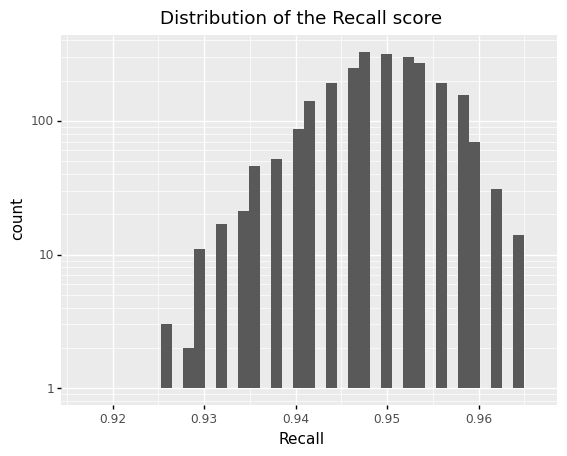

<ggplot: (8776360785195)>

In [40]:
(
    ggplot(Scores, aes(x='Recall'))
    + geom_histogram()
    + scale_y_continuous(
        trans = "log10"
    )
    + ggtitle('Distribution of the Recall score')
)

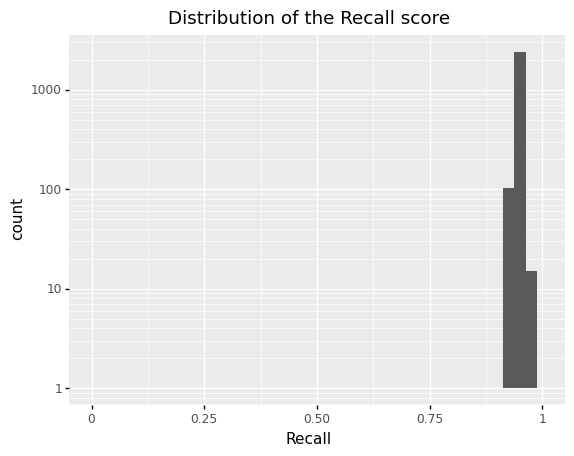

<ggplot: (8776360674042)>

In [41]:
(
    ggplot(Scores, aes(x='Recall'))
    + geom_histogram()
    + scale_y_continuous(
        trans = "log10"
    )
    + xlim(0, 1)
    + ggtitle('Distribution of the Recall score')
)

We can say with 90% probability that the true Recall score will be higher than 0.94.  So, we will use 0.94 as our worst-case estimate for Recall.  Note, that all of this analysis is done very conservatively by using weaker models with only 25% (~1400 samples) of the training data.  If we had not been so conservative, then the distribution would have been too narrow to investigate.

With a 0.94 Recall score, our worst-case scenario is that, out of 100 Death events, we would miss 6.

In [59]:
print( f'samplings: {len(Scores.Recall) }')
print( f'mean: {np.mean(Scores.Recall) }')
print( f'median: {np.median(Scores.Recall) }')
print( f'quantile - [0.05, 0.10]: {np.quantile(Scores.Recall, [0.05, 0.10]) }')

samplings: 2500
mean: 0.949211222444898
median: 0.9498997995991983
quantile - [0.05, 0.10]: [0.93787575 0.94188377]


In [46]:
Scores[Scores['Recall'] < .94].shape[0] / Scores.shape[0]

0.0964

In [42]:
Scores[Scores['Recall'] < 0.93].shape[0] / Scores.shape[0]

0.0072